In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import tensorflow_probability as tfp
from scipy.interpolate import RectBivariateSpline
import numpy as np
import matplotlib.pyplot as plt
import corner
import importlib
import logging
from tensorflow import keras
import os
from functions import chi2_graph

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
importlib.reload(logging)
gpus = tf.config.experimental.list_physical_devices('GPU')
try:
    tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
    tf.config.experimental.set_virtual_device_configuration(gpus[1],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
except RuntimeError as e:
    print(e)

2 Physical GPUs, 1 Logical GPU


In [2]:
data = np.load('../../Data/sample_NuFit0911.npz')
data_all = np.column_stack([data['ve_dune'][:,:36], data['vu_dune'][:,:36], data['vebar_dune'][:,:36], data['vubar_dune'][:,:36]])

In [3]:
gaussian_number = 10
latent_dim = 10

In [5]:
model_name = 'test/5'
path = './cvae/{}/'.format(model_name)
encoder1 = load_model(path + "encoder_1.h5", compile=False)
encoder2 = load_model(path + "encoder_2.h5", compile=False)
decoder = load_model(path + "decoder.h5", compile=False)

In [6]:
n = 0
data_poisson_array = data_all[n:n+1]/1000

mean, log_var, weight = encoder2.predict(data_poisson_array)

mean = tf.reshape(mean, (-1, gaussian_number, latent_dim))
log_var = tf.reshape(log_var, (-1, gaussian_number, latent_dim))
weight = tf.reshape(weight, (-1, gaussian_number))

SMALL_CONSTANT = 1e-12
temp_var = SMALL_CONSTANT + tf.exp(log_var)
test_sampling = tfp.distributions.MixtureSameFamily(
              mixture_distribution=tfp.distributions.Categorical(logits=weight),
              components_distribution=tfp.distributions.MultivariateNormalDiag(
              loc=mean,
              scale_diag=tf.sqrt(temp_var)))

sample_amount= 100000
sample_times = 10
prediction = []
for i in range(sample_times):
    Z3 = np.reshape(test_sampling.sample(sample_shape=(sample_amount)), (sample_amount, latent_dim))
    reconstruction_mean, reconstruction_var = decoder.predict([Z3, np.array(([data_poisson_array[0]]*sample_amount))])
    temp_var = SMALL_CONSTANT + tf.exp(reconstruction_var)
    reconstruction_parameter = tfp.distributions.MultivariateNormalDiag(
                            loc=reconstruction_mean,
                            scale_diag=temp_var)
    prediction.extend(reconstruction_parameter.sample().numpy())

prediction_IO = np.array(prediction)

In [7]:
n = 0
data_poisson_array = data_all[1:2]/1000

mean, log_var, weight = encoder2.predict(data_poisson_array)

mean = tf.reshape(mean, (-1, gaussian_number, latent_dim))
log_var = tf.reshape(log_var, (-1, gaussian_number, latent_dim))
weight = tf.reshape(weight, (-1, gaussian_number))

SMALL_CONSTANT = 1e-12
temp_var = SMALL_CONSTANT + tf.exp(log_var)
test_sampling = tfp.distributions.MixtureSameFamily(
              mixture_distribution=tfp.distributions.Categorical(logits=weight),
              components_distribution=tfp.distributions.MultivariateNormalDiag(
              loc=mean,
              scale_diag=tf.sqrt(temp_var)))

sample_amount= 100000
sample_times = 10
prediction = []
for i in range(sample_times):
    Z3 = np.reshape(test_sampling.sample(sample_shape=(sample_amount)), (sample_amount, latent_dim))
    reconstruction_mean, reconstruction_var = decoder.predict([Z3, np.array(([data_poisson_array[0]]*sample_amount))])
    temp_var = SMALL_CONSTANT + tf.exp(reconstruction_var)
    reconstruction_parameter = tfp.distributions.MultivariateNormalDiag(
                            loc=reconstruction_mean,
                            scale_diag=temp_var)
    prediction.extend(reconstruction_parameter.sample().numpy())

prediction_NO = np.array(prediction)

In [8]:
np.savez('./contour_IO/cvae.npz', prediction_IO)
np.savez('./contour_NO/cvae.npz', prediction_NO)

In [12]:
x, y, X, Y, Z = chi2_graph()

/tmp/ipykernel_498512/2514506408.py:11: UserWarning: No contour levels were found within the data range.
  DUT2 = plot_axis.contour(X0, Y0, Z0, 0, colors='blue', linestyles="-", linewidths=1)


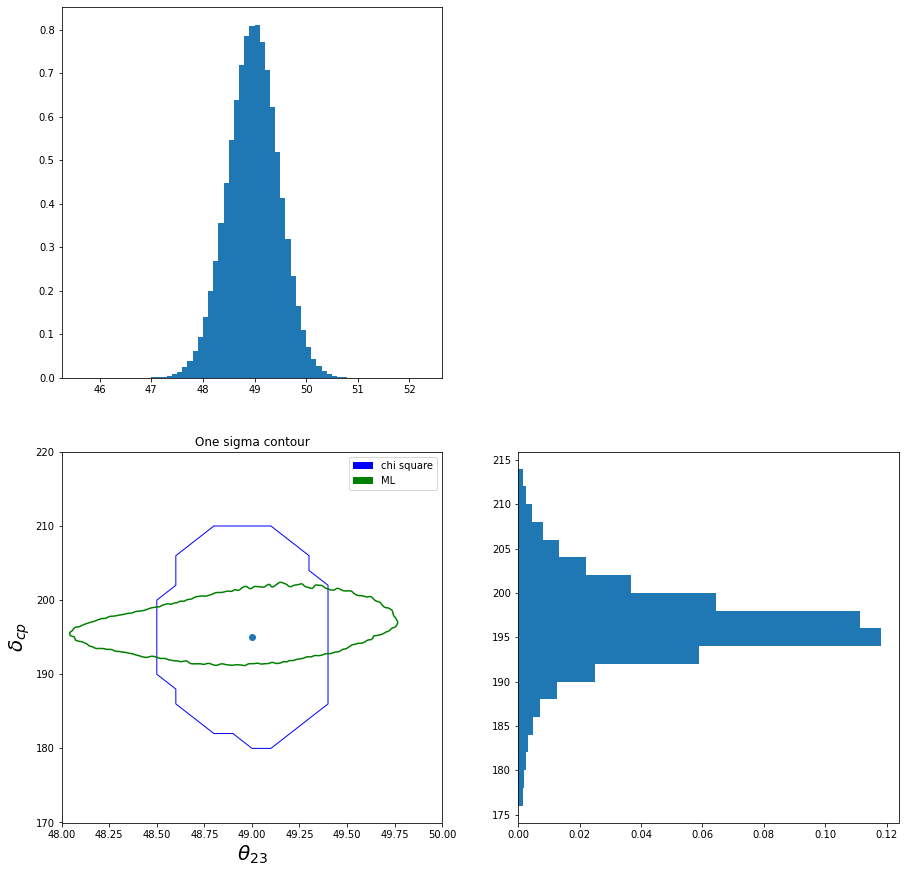

In [16]:
fig, ax = plt.subplots(1,1, figsize=(15,15))
plot_axis = plt.subplot(2,2,1)
plot_axis.hist(prediction_IO[:, 1]*180/np.pi,density=1,bins=x)

plot_axis = plt.subplot(2,2,4)

plot_axis.hist(prediction_IO[:, 2]*180/np.pi,orientation="horizontal",density=1, bins=y)

plot_axis = plt.subplot(2,2,3)
plot_axis.set_title('One sigma contour')
DUT2 = plot_axis.contour(X, Y, Z, 0, colors='blue', linestyles="-", linewidths=1)
corner.hist2d(prediction_IO[:, 1]*180/np.pi, prediction_IO[:, 2]*180/np.pi,
                    levels=(0.68,),
                    scale_hist=True,
                    plot_datapoints=False,
                    color='green',
                    labels= ["$\\theta_{23} $($^\circ$)", "$\delta_{cp} $($^\circ$)"],
                    range=[[48,50], [170, 220]],
                    plot_contours = True,
                    plot_density = False,
                    fontsize=30,
                    bins = [200, 200],
                    label_kwargs={"fontsize": 30},
                    smooth=True
                   )
plt.scatter(data['theta23'][0], data['delta'][0])
plot_axis.set_xlabel(r'$\theta_{23} $', fontsize=20)
plot_axis.set_ylabel(r'$\delta_{cp} $', fontsize=20)
proxy = [plt.Rectangle((2, 2), 0.0, 3, 90, fc=c) for c in ['blue', 'green']]
plt.legend(proxy, ["chi square", "ML"])
plt.show()